In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fastqaoa.utils import styling
from problems import Knapsack

from circuit_lengths import add_lengths_to_df, layer_depth_qpe

from regressor import fit_multi

styling.set_my_style()

In [2]:
df = pd.read_feather("../../results/qpe_main2_nft.feather")

df["depth"] = df.depth.astype(int)
df["problem_id"] = df.problem_id.astype(int)

<Axes: xlabel='n_qubits', ylabel='rnd_approx_ratio'>

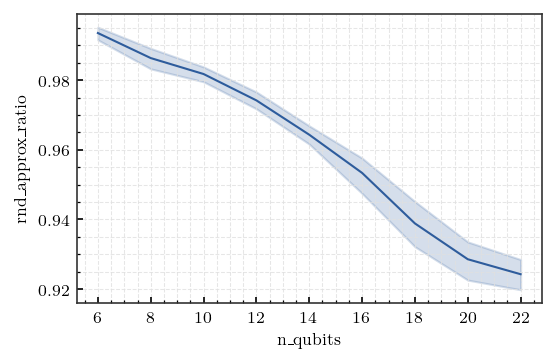

In [3]:
sns.lineplot(df.query("ancilla.isna() and depth == 32"), x="n_qubits", y="rnd_approx_ratio")

<Axes: xlabel='n_qubits', ylabel='rnd_approx_ratio'>

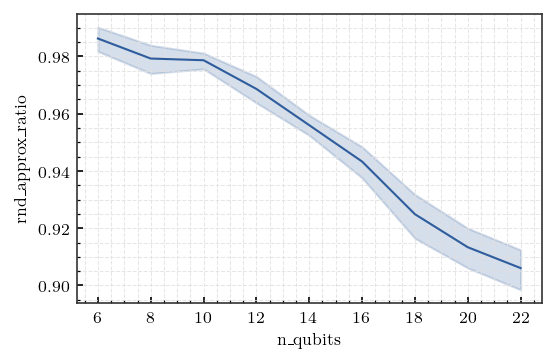

In [4]:
sns.lineplot(df.query("ancilla == 8 and depth == 32"), x="n_qubits", y="rnd_approx_ratio")

In [5]:
instances = Knapsack.get_instances()

def layer_func(x):
    instance = instances[x.n_qubits][x.problem_id]
    return layer_depth_qpe(instance, M=x.ancilla)

In [6]:
df = df.query("not ancilla.isna()")
df["ancilla"] = df.ancilla.astype(int)

df["layer_depth"] = df.apply(layer_func, axis=1)

df["expected_depth_num"] = df.q_succ.apply(lambda x: np.cumprod(x[:-1]).sum() + 1)
df["p_total"] = df.p_opt * df.p_succ

# df["scale"] = np.sum(1 / np.cumprod(x[::-1])[::-1])

df["repeats"] = np.ceil(np.log(0.01) / np.log(1 - df.p_total))

df["tts"] = (1 + df.layer_depth * df.expected_depth_num) * df.repeats
df["log_tts"] = np.log10(df.tts)

df_fit = fit_multi(df, x="n_qubits", y="log_tts", groupby=["ancilla", "depth"])

df_opt = df.groupby(["problem_id", "ancilla", "n_qubits"], group_keys=False).apply(lambda x: x.iloc[x.tts.argmin()], include_groups=False).reset_index()
df_opt_fit = fit_multi(df_opt.query("depth >= 6"), x="n_qubits", y="log_tts", groupby=["ancilla"])
df_opt["n_qubits_log"] = np.log10(df_opt.n_qubits)
df_opt_fit2 = fit_multi(df_opt, x="n_qubits_log", y="log_tts", groupby=["ancilla"])

In [7]:
x = df.q_succ.iloc[5]
x

array([0.97285522, 0.93891393, 0.92888235, 0.91012613, 0.87879721,
       0.86216315, 0.87018904, 0.89163508])

In [8]:
df.query("ancilla == 4 and depth == 32 and n_qubits == 16").p_opt

52233    0.638392
52293    0.238053
52353    0.007601
52413    0.005278
52473    0.200472
           ...   
59613    0.173102
59673    0.128875
59733    0.011421
59793    0.110389
59853    0.015798
Name: p_opt, Length: 128, dtype: float64

In [9]:
np.sum(np.log(0.01) / np.log(1 - np.cumprod(x[::-1])))

np.float64(42.16620237153251)

In [10]:
1 / np.prod(x[1:])

np.float64(2.143053628652496)

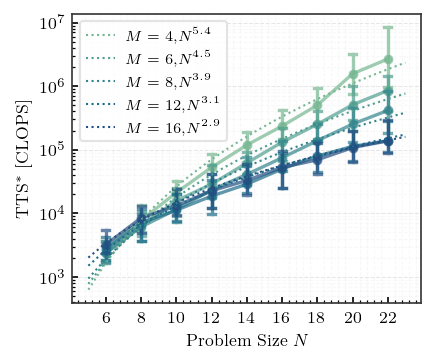

In [11]:
palette = styling.shades(6, 4)[1:]
palette = sns.color_palette("crest", 5)


styling.subplots(figsize=(3, 2.5))
# sns.stripplot(df_opt, x="n_qubits", y="tts", hue="method", dodge=0.3, legend=False, alpha=0.1)#, errorbar=("pi",50), estimator=np.median)
sns.pointplot(df_opt, x="n_qubits", y="tts", hue="ancilla", errorbar=("pi", 50), estimator=np.median, palette=palette, legend=False, capsize=0.2, alpha=0.7, linewidth=1.6, markersize=3.5)

c = 0
def plot_fit(d):
    global c
    x  = np.linspace(5, 23, 2)
    y = 10 **  d.slope
    plt.plot((x-6) / 2,  10 ** (d.intercept + d.slope * x), linestyle="--", color=palette[c], label=f"$M = {d.name}$, {y:.2f}$^N$")
    c += 1

# df_opt_fit.apply(plot_fit, axis=1)

c = 0
def plot_fit2(d):
    global c
    x  = np.linspace(5, 23, 20)
    plt.plot((x-6) / 2,  x ** d.slope * 10 ** d.intercept, linestyle=":", color=palette[c], label=f"$M = {d.name}$," + "$N^{" +f"{d.slope:.1f}" + "}$")
    c += 1

df_opt_fit2.apply(plot_fit2, axis=1)

# plt.xscale("log")

plt.yscale("log")
plt.legend()

plt.xlabel("Problem Size $N$")
plt.ylabel(r"TTS$^*$ [CLOPS]")

df_opt_fit

plt.savefig("plots/qpe_tts_scaling_pl.pdf")

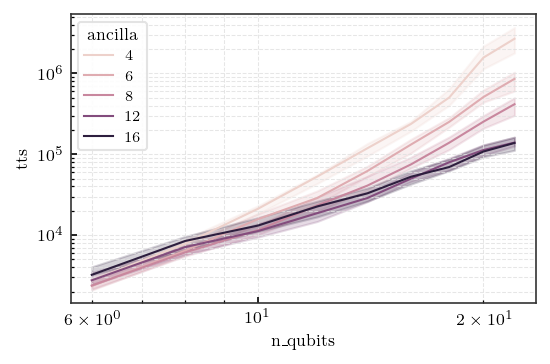

In [62]:
sns.lineplot(df_opt, x="n_qubits", y="tts", hue="ancilla", estimator=np.median)
plt.yscale("log")
plt.xscale("log")


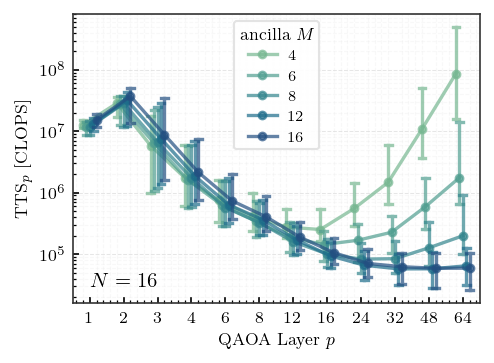

In [63]:
styling.subplots(figsize=(3.5, 2.5))

sns.pointplot(df.query("n_qubits == 16"), x="depth", y="tts", hue="ancilla", palette=palette, estimator=np.median, errorbar=("pi", 50), dodge=0.4, capsize=0.2, alpha=0.7, linewidth=1.6, markersize=3.5)
plt.yscale("log")
leg = plt.gca().get_legend()
leg.set_title("ancilla $M$")
plt.xlabel("QAOA Layer $p$")
plt.ylabel(r"TTS$_p$ [CLOPS]")

plt.text(s="$N = 16$", x=0, y=3*10**4)


plt.savefig("plots/qpe_tts.pdf")

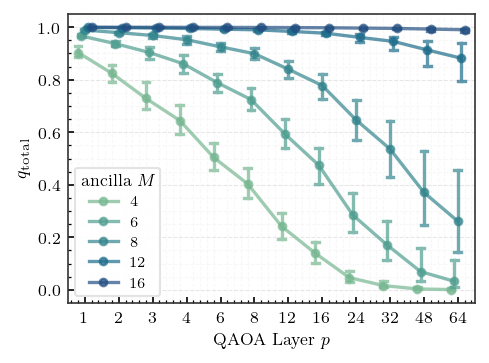

In [11]:
styling.subplots(figsize=(3.5, 2.5))

sns.pointplot(df, x="depth", y="p_succ", hue="ancilla", palette=palette, estimator=np.median, errorbar=("pi", 50), dodge=0.4, capsize=0.2, alpha=0.7, linewidth=1.6, markersize=3.5)
# plt.yscale("log")
plt.xlabel("QAOA Layer $p$")
leg = plt.gca().get_legend()
leg.set_title("ancilla $M$")
plt.ylabel(r"$q_{\mathrm{total}}$")

plt.savefig("plots/qpe_psucc.pdf")